# Thermal Noise Simulation


Noiseless Probabilities:
  |00000001>: 0.5122
  |00000010>: 0.2422
  |00000100>: 0.1295
  |00001000>: 0.0706
  |00010000>: 0.0235
  |00100000>: 0.0118
  |01000000>: 0.0084
  |10000000>: 0.0017

Noisy Probabilities:
  |00000001>: 0.5156
  |00000010>: 0.2993
  |00000100>: 0.1419
  |00001000>: 0.0277
  |00010000>: 0.0156


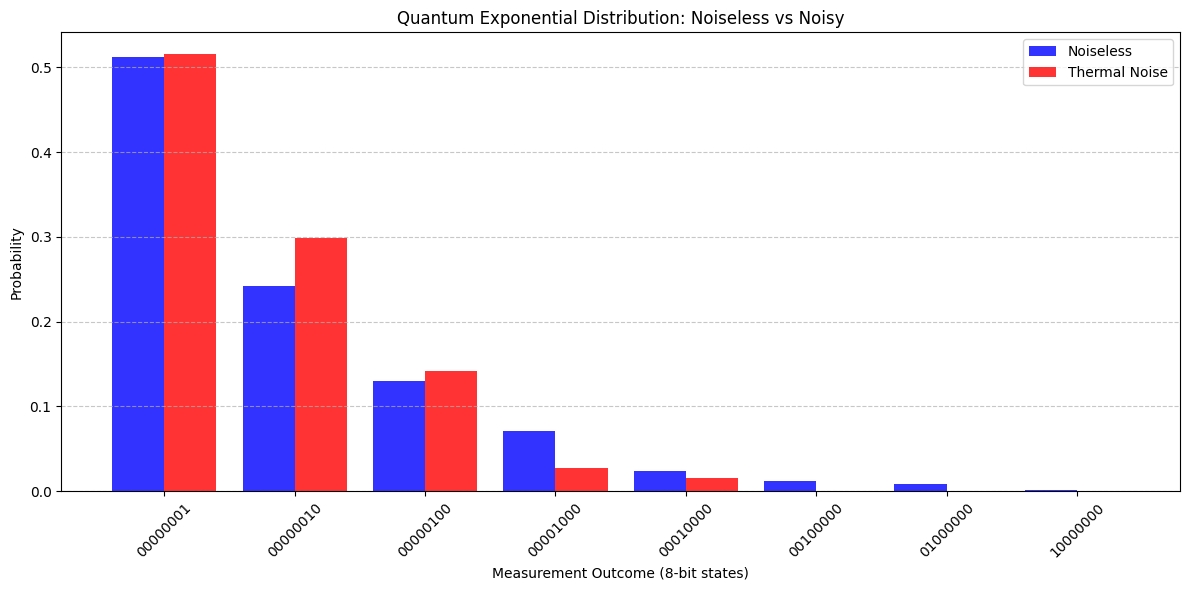

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, thermal_relaxation_error
import matplotlib.pyplot as plt
import numpy as np


def build_quantum_exponential_distribution_circuit(num_qubits: int, decay) -> QuantumCircuit:
    """
    Constructs a quantum circuit to simulate an exponential distribution using RX and CSWAP gates.

    Parameters:
        num_qubits (int): Number of qubits to represent the distribution.
        decay (float): Decay constant controlling the exponential shape.

    Returns:
        QuantumCircuit: Configured quantum circuit for exponential distribution.
    """
    # Create quantum and classical registers
    q = QuantumRegister(num_qubits + 2, 'q')  # q[0] is ancilla, q[num_qubits+1] is temp ancilla
    c = ClassicalRegister(num_qubits, 'c')    # c[0] to c[num_qubits-1] read q[1] to q[num_qubits]
    qc = QuantumCircuit(q, c)

    # Compute RX rotation angle based on decay parameter
    theta = 2 * np.arccos(np.sqrt(decay / (1 + decay)))

    # Set initial state (impulse) at q[1]
    qc.x(q[1])

    # Apply cascaded CSWAPs with RX control to distribute amplitude
    for block in range(1, num_qubits):
        qc.rx(theta, q[0])  # Ancilla RX rotation for controlling decay behavior

        # Perform controlled swaps to propagate the amplitude forward
        for swap in range(1, block):
            qc.cswap(q[0], q[swap], q[num_qubits + 1])  # CSWAP between current and temp
            qc.reset(q[num_qubits + 1])                 # Reset temp ancilla for reuse

        # Final swap for this layer
        qc.cswap(q[0], q[block], q[block + 1])
        qc.reset(q[0])  # Reset main ancilla for next iteration

    # Measure distribution qubits into classical bits
    for i in range(1, num_qubits + 1):
        qc.measure(q[i], c[i - 1])

    return qc


def build_thermal_noise_model(t1=7e3, t2=5e3, gate_time=1000):
    """
    Constructs a noise model based on thermal relaxation for simulating decoherence.

    Parameters:
        t1 (float): Relaxation time T1 in nanoseconds.
        t2 (float): Dephasing time T2 in nanoseconds.
        gate_time (float): Time each gate operation takes in nanoseconds.

    Returns:
        NoiseModel: Configured Qiskit thermal noise model.
    """
    noise_model = NoiseModel()
    error_1q = thermal_relaxation_error(t1, t2, gate_time)              # Single-qubit error
    error_2q = error_1q.tensor(error_1q)                                # Two-qubit error
    error_3q = error_1q.tensor(error_1q).tensor(error_1q)               # Three-qubit error

    # Add thermal errors to all relevant gates
    for gate in ['x', 'h', 'rx', 'reset']:
        noise_model.add_all_qubit_quantum_error(error_1q, gate)

    noise_model.add_all_qubit_quantum_error(error_2q, 'cx')
    noise_model.add_all_qubit_quantum_error(error_3q, 'cswap')

    return noise_model


def run_simulation(qc: QuantumCircuit, noise_model=None, shots: int = 10000):
    """
    Simulates the quantum circuit with or without a noise model.

    Parameters:
        qc (QuantumCircuit): The quantum circuit to simulate.
        noise_model (NoiseModel, optional): Noise model to apply during simulation.
        shots (int): Number of measurement shots to perform.

    Returns:
        dict: Measurement result counts.
    """
    simulator = AerSimulator(noise_model=noise_model)
    compiled_circuit = transpile(qc, simulator)
    result = simulator.run(compiled_circuit, shots=shots).result()
    return result.get_counts(qc)


def calculate_probabilities(counts: dict, num_qubits: int):
    """
    Converts raw counts to normalized probabilities, excluding all-zero state.

    Parameters:
        counts (dict): Measurement result counts from simulation.
        num_qubits (int): Number of measured qubits.

    Returns:
        dict: Normalized probabilities for non-zero outcomes.
    """
    zero_state = '0' * num_qubits
    filtered_counts = {k: v for k, v in counts.items() if k != zero_state}
    total = sum(filtered_counts.values())
    return {k: v / total for k, v in filtered_counts.items()}


def plot_comparison(probabilities_list, labels, colors, num_qubits):
    """
    Plots a bar chart comparing different sets of probability distributions.

    Parameters:
        probabilities_list (list): List of dictionaries with state probabilities.
        labels (list): Labels for each probability distribution.
        colors (list): Colors for each distribution's bars.
        num_qubits (int): Number of qubits used to determine state length.
    """
    all_states = sorted(set().union(*[p.keys() for p in probabilities_list]), key=lambda x: int(x, 2))
    x = np.arange(len(all_states))
    width = 0.8 / len(probabilities_list)

    plt.figure(figsize=(12, 6))
    for i, (probs, label, color) in enumerate(zip(probabilities_list, labels, colors)):
        y = [probs.get(state, 0) for state in all_states]
        plt.bar(x + (i - len(probabilities_list)/2)*width + width/2, y, width, label=label, color=color, alpha=0.8)

    plt.xlabel(f"Measurement Outcome ({num_qubits}-bit states)")
    plt.ylabel("Probability")
    plt.title("Quantum Exponential Distribution: Noiseless vs Noisy")
    plt.xticks(x, all_states, rotation=45)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


def main(num_qubits=8, decay=2, shots=10000):
    """
    Main function to run the exponential distribution circuit and visualize the results.

    Parameters:
        num_qubits (int): Number of distribution qubits.
        decay (float): Decay constant for RX angle.
        shots (int): Number of simulation shots.
    """
    # Build quantum circuit
    qc = build_quantum_exponential_distribution_circuit(num_qubits, decay)

    # Run noiseless simulation
    counts_clean = run_simulation(qc, noise_model=None, shots=shots)
    probs_clean = calculate_probabilities(counts_clean, num_qubits)

    # Run noisy simulation with thermal relaxation model
    noise_model = build_thermal_noise_model()
    counts_noisy = run_simulation(qc, noise_model=noise_model, shots=shots)
    probs_noisy = calculate_probabilities(counts_noisy, num_qubits)

    # Display probabilities
    print("\nNoiseless Probabilities:")
    for s, p in sorted(probs_clean.items(), key=lambda x: int(x[0], 2)):
        print(f"  |{s}>: {p:.4f}")

    print("\nNoisy Probabilities:")
    for s, p in sorted(probs_noisy.items(), key=lambda x: int(x[0], 2)):
        print(f"  |{s}>: {p:.4f}")

    # Plot side-by-side comparison
    plot_comparison(
        probabilities_list=[probs_clean, probs_noisy],
        labels=['Noiseless', 'Thermal Noise'],
        colors=['blue', 'red'],
        num_qubits=num_qubits
    )


if __name__ == "__main__":
    main()


# Noise Optimization Using ZNE (Zero Noise Extrapolation)

Running quantum exponential distribution simulation with 8 qubits...
Shots: 5000, Decay rate: 2.718
Circuit depth: 57

1. Running noiseless simulation...
2. Running noisy simulation...
3. Running zero-noise extrapolation...
  Running with noise factor 0.5...
  Running with noise factor 1.0...
  Running with noise factor 1.5...

Method                    Fidelity            
---------------------------------------------
Noisy                     0.7884              
Zero-Noise Extrapolated   0.9714              


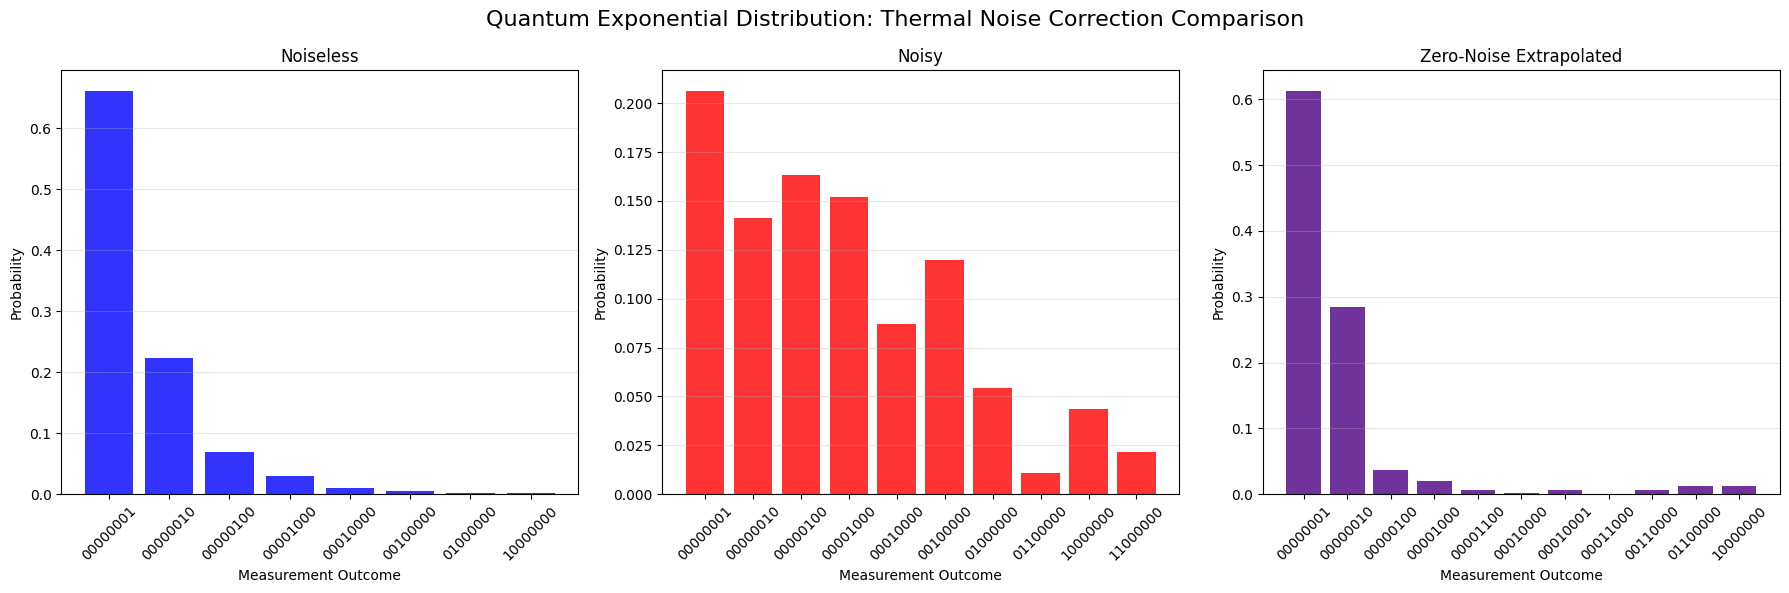

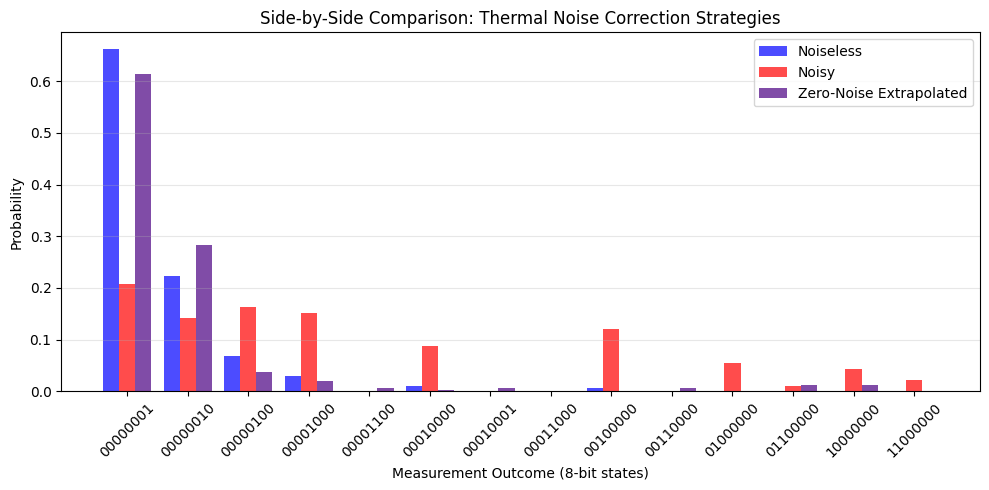

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, thermal_relaxation_error, depolarizing_error
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict


def build_quantum_exponential_distribution_circuit(num_qubits: int, decay: float) -> QuantumCircuit:
    """
    Constructs the quantum exponential distribution circuit using RX and CSWAP gates.
    
    Parameters:
        num_qubits (int): Number of qubits used for encoding the distribution.
        decay (float): Decay rate for exponential distribution.

    Returns:
        QuantumCircuit: The constructed quantum circuit.
    """
    # Define quantum and classical registers
    q = QuantumRegister(num_qubits + 2, 'q')  # +2 for ancilla qubits: q[0] and q[num_qubits+1]
    c = ClassicalRegister(num_qubits, 'c')    # Classical bits to record measurements
    qc = QuantumCircuit(q, c)

    # Rotation angle to approximate exponential distribution
    theta = 2 * np.arccos(np.sqrt(decay / (1 + decay)))

    # Set the second qubit (q[1]) to |1⟩ as initial state
    qc.x(q[1])

    # Apply RX and CSWAP blocks to spread amplitude
    for block in range(1, num_qubits):
        qc.rx(theta, q[0])  # Apply RX gate on ancilla q[0]

        # Nested CSWAPs using q[num_qubits+1] as temporary ancilla
        for swap in range(1, block):
            qc.cswap(q[0], q[swap], q[num_qubits + 1])
            qc.reset(q[num_qubits + 1])

        # Final CSWAP step
        qc.cswap(q[0], q[block], q[block + 1])
        qc.reset(q[0])  # Reset main control ancilla q[0]

    # Measure q[1] through q[num_qubits] into classical register
    for i in range(1, num_qubits + 1):
        qc.measure(q[i], c[i - 1])

    return qc


def build_thermal_noise_model(t1=5e3, t2=1e3, gate_time=30000, depol_prob=0.05):
    """
    Builds a comprehensive thermal noise model with both relaxation and depolarizing errors.
    """
    noise_model = NoiseModel()

    # 1-qubit thermal and depolarizing errors
    thermal_error_1q = thermal_relaxation_error(t1, t2, gate_time)
    depol_error_1q = depolarizing_error(depol_prob, 1)
    combined_error_1q = thermal_error_1q.compose(depol_error_1q)

    # 2-qubit errors
    thermal_error_2q = thermal_error_1q.tensor(thermal_error_1q)
    depol_error_2q = depolarizing_error(depol_prob * 2, 2)
    combined_error_2q = thermal_error_2q.compose(depol_error_2q)

    # 3-qubit errors
    thermal_error_3q = thermal_error_1q.tensor(thermal_error_1q).tensor(thermal_error_1q)
    depol_error_3q = depolarizing_error(depol_prob * 3, 3)
    combined_error_3q = thermal_error_3q.compose(depol_error_3q)

    # Add errors to gates
    for gate in ['x', 'rx', 'reset']:
        noise_model.add_all_qubit_quantum_error(combined_error_1q, gate)

    noise_model.add_all_qubit_quantum_error(combined_error_2q, 'cx')
    noise_model.add_all_qubit_quantum_error(combined_error_3q, 'cswap')

    return noise_model


def run_simulation(qc: QuantumCircuit, shots: int = 1000, use_noise: bool = True, noise_factor: float = 1.0):
    """
    Runs the quantum simulation with optional thermal noise.
    
    Parameters:
        noise_factor: Scaling factor for noise (1.0 = base noise level)
    """
    if use_noise:
        noise_model = build_thermal_noise_model(
            t1=50e3/noise_factor, 
            t2=7e3/noise_factor, 
            depol_prob=0.001*noise_factor
        )
        simulator = AerSimulator(noise_model=noise_model)
    else:
        simulator = AerSimulator()
    
    compiled = transpile(qc, simulator)
    job = simulator.run(compiled, shots=shots)
    result = job.result()
    return result.get_counts(qc)


def calculate_probabilities(counts: dict, num_qubits: int) -> dict:
    """
    Calculates normalized measurement probabilities from counts,
    excluding the all-zero state and properly normalizing.
    """
    # Remove the all-zero state if present
    zero_state = '0' * num_qubits
    filtered_counts = {
        state: count for state, count in counts.items() if state != zero_state
    }

    total = sum(filtered_counts.values())
    return {
        state: count / total for state, count in filtered_counts.items()
    }


def calculate_fidelity(probs1: dict, probs2: dict) -> float:
    """
    Calculate fidelity between two probability distributions.
    """
    all_states = set(probs1.keys()) | set(probs2.keys())
    fidelity = 0
    for state in all_states:
        p1 = probs1.get(state, 0)
        p2 = probs2.get(state, 0)
        fidelity += np.sqrt(p1 * p2)
    return fidelity


def plot_comprehensive_comparison(results_dict: dict, num_qubits: int):
    """
    Creates a comprehensive side-by-side comparison of all simulation results.
    Only plots states with non-zero probabilities.
    """
    # Get all unique states that have non-zero probabilities in at least one method
    all_nonzero_states = set()
    for probs in results_dict.values():
        all_nonzero_states.update([state for state, prob in probs.items() if prob > 0])
    
    all_states = sorted(all_nonzero_states, key=lambda x: int(x, 2) if x else 0)
    
    n_methods = len(results_dict)
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Quantum Exponential Distribution: Thermal Noise Correction Comparison', fontsize=16)
    
    # Individual plots
    colors = ['blue', 'red', 'indigo']
    for idx, (label, probs) in enumerate(results_dict.items()):
        ax = axes[idx]
        
        # Only include states with non-zero probabilities for this method
        nonzero_states = [state for state in probs.keys() if probs[state] > 0]
        nonzero_states = sorted(nonzero_states, key=lambda x: int(x, 2) if x else 0)
        probabilities = [probs[state] for state in nonzero_states]
        
        if nonzero_states:  # Only plot if there are non-zero states
            ax.bar(range(len(nonzero_states)), probabilities, color=colors[idx % len(colors)], alpha=0.8)
            ax.set_xticks(range(len(nonzero_states)))
            ax.set_xticklabels(nonzero_states, rotation=45)
        
        ax.set_title(f'{label}', fontsize=12)
        ax.set_xlabel('Measurement Outcome')
        ax.set_ylabel('Probability')
        ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Side-by-side comparison
    plt.figure(figsize=(10, 5))
    
    x = np.arange(len(all_states))
    width = 0.8 / n_methods
    
    for idx, (label, probs) in enumerate(results_dict.items()):
        # Only include non-zero probabilities
        probs_list = [probs.get(state, 0) for state in all_states]
        offset = (idx - n_methods/2 + 0.5) * width
        plt.bar(x + offset, probs_list, width, label=label, 
               color=colors[idx % len(colors)], alpha=0.7)
    
    plt.xlabel(f'Measurement Outcome ({num_qubits}-bit states)')
    plt.ylabel('Probability')
    plt.title('Side-by-Side Comparison: Thermal Noise Correction Strategies')
    plt.xticks(x, all_states, rotation=45)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()


def main(num_qubits=8, decay=2.718, shots=5000):
    """
    Comprehensive simulation comparing noiseless, noisy, and error-corrected versions.
    """
    print(f"Running quantum exponential distribution simulation with {num_qubits} qubits...")
    print(f"Shots: {shots}, Decay rate: {decay}")
    
    # Build circuit
    qc = build_quantum_exponential_distribution_circuit(num_qubits, decay)
    print(f"Circuit depth: {qc.depth()}")
    
    results = {}
    fidelities = {}
    
    # 1. Noiseless simulation
    print("\n1. Running noiseless simulation...")
    counts_clean = run_simulation(qc, shots=shots, use_noise=False)
    probs_clean = calculate_probabilities(counts_clean, num_qubits)
    results['Noiseless'] = probs_clean
    
    # 2. Noisy simulation
    print("2. Running noisy simulation...")
    counts_noisy = run_simulation(qc, shots=shots, use_noise=True)
    probs_noisy = calculate_probabilities(counts_noisy, num_qubits)
    results['Noisy'] = probs_noisy
    fidelities['Noisy'] = calculate_fidelity(probs_clean, probs_noisy)
    
    # 3. Zero-noise extrapolation
    print("3. Running zero-noise extrapolation...")
    noise_levels = [0.5, 1.0, 1.5]  # Different noise scaling factors
    extrapolated_probs = {}
    
    # Run simulations at different noise levels
    noise_results = []
    for noise_factor in noise_levels:
        print(f"  Running with noise factor {noise_factor}...")
        counts = run_simulation(qc, shots=shots, use_noise=True, noise_factor=noise_factor)
        probs = calculate_probabilities(counts, num_qubits)
        noise_results.append(probs)
    
    # Simple linear extrapolation to zero noise
    all_states_extrap = set().union(*[probs.keys() for probs in noise_results])
    for state in all_states_extrap:
        probs_at_noise = [probs.get(state, 0) for probs in noise_results]
        # Linear extrapolation: y = a + b*x, solve for x=0
        if len(set(probs_at_noise)) > 1:  # Only extrapolate if there's variation
            coeffs = np.polyfit(noise_levels, probs_at_noise, 1)
            extrapolated_prob = coeffs[1]  # y-intercept
            if extrapolated_prob > 0:
                extrapolated_probs[state] = max(0, extrapolated_prob)
    
    # Normalize
    total_prob = sum(extrapolated_probs.values())
    if total_prob > 0:
        extrapolated_probs = {state: prob/total_prob for state, prob in extrapolated_probs.items()}
    
    results['Zero-Noise Extrapolated'] = extrapolated_probs
    fidelities['Zero-Noise Extrapolated'] = calculate_fidelity(probs_clean, extrapolated_probs)
    
    # Print results
    print(f"\n{'Method':<25} {'Fidelity':<20}")
    print("-" * 45)
    for method, fidelity in fidelities.items():
        print(f"{method:<25} {fidelity:<20.4f}")
    
    # Plot comprehensive comparison
    plot_comprehensive_comparison(results, num_qubits)
    
    return results, fidelities


if __name__ == "__main__":
    results, fidelities = main(num_qubits=8, decay=2.718, shots=5000)